<a href="https://colab.research.google.com/github/MateoVB/AIT-Deep-Learning/blob/main/10_Telco_churn_residual_skip_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright
<pre>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</pre>

This code shows an example how to predict the churn probability of a telecommunication company. Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy

Next, we download the dataset:

In [2]:
!wget https://deeplearningoktatas.hu/downloads/tabular/telco_churn.csv -O telco_churn.csv

--2024-05-09 15:30:47--  https://deeplearningoktatas.hu/downloads/tabular/telco_churn.csv
Resolving deeplearningoktatas.hu (deeplearningoktatas.hu)... 91.227.138.51
Connecting to deeplearningoktatas.hu (deeplearningoktatas.hu)|91.227.138.51|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.deeplearningoktatas.hu/downloads/tabular/telco_churn.csv [following]
--2024-05-09 15:30:47--  https://www.deeplearningoktatas.hu/downloads/tabular/telco_churn.csv
Resolving www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)... 91.227.138.51
Connecting to www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)|91.227.138.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/csv]
Saving to: ‘telco_churn.csv’

telco_churn.csv     100%[===================>] 954.59K  --.-KB/s    in 0.1s    

2024-05-09 15:30:48 (7.10 MB/s) - ‘telco_churn.csv’ saved [977501/977501]



## Dataset loading and preprocessing
In the following blocks we load the data into a Pandas dataframe and prepare it for training.

In [3]:
df = pd.read_csv("telco_churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
del df['customerID'] # we don't need this field

We explore the data:

In [7]:
df['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [8]:
df['MultipleLines'].value_counts()

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

In [9]:
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [10]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


After inspecting the dataframe with df.head(), we collect the categorical and numerical features manually:

In [11]:
cat_feats = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
             'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [12]:
num_feats = ['MonthlyCharges', 'TotalCharges', 'tenure']

We convert the categorical features to one-shot encodings:

In [15]:
df_categorical = pd.get_dummies(df[cat_feats])

And concatenate the one-hots with the original numerical features:

In [16]:
df_final = pd.concat((df[num_feats], df_categorical), axis=1)

TotalCharges is stored as strings. For simlicity, we delete this feature as well (a better approach would be to cast it to floats):

In [17]:
del df_final['TotalCharges']

And we prepare the inputs and outputs for the neural network:

In [18]:
X = df_final.values
Y = pd.get_dummies(df['Churn'])
Y = Y["Yes"].values

In [19]:
X.shape, Y.shape

((7043, 44), (7043,))

In [30]:
X = X.astype(float)
Y = Y.astype(float)

We split the data into training, validation and test sets:

In [31]:
valid_split = 0.2
test_split  = 0.1

v_point = int(X.shape[0]*(1-valid_split-test_split))
t_point = int(X.shape[0]*(1-test_split))

X_train = X[:v_point]
Y_train = Y[:v_point]
X_valid = X[v_point:t_point]
Y_valid = Y[v_point:t_point]
X_test  = X[t_point:]
Y_test  = Y[t_point:]

And we standardize the numerical features only:

In [32]:
scaler  = preprocessing.StandardScaler().fit(X_train[:,0:2])

In [33]:
X_train[:,0:2] = scaler.transform(X_train[:,0:2])
X_valid[:,0:2] = scaler.transform(X_valid[:,0:2])
X_test[:,0:2]  = scaler.transform(X_test[:,0:2])

## Exercise: Model definition

Next, let's define the model. We use a single output with sigmoid for binary classification (churn or no churn?).
A quite simple model would be enough here with a few hundreds of learnable parameters and 1-2 layers. However, to demonstrate the robustness of residual and skip connections, let's construct a neural network with:
* 10 layers, 20 neurons / layers with sigmoid activation
* residual connections for each layer
* skip connections from every 2nd layer
* an output layer with 1 neuron and sigmoid activation (as this is a binary classification problem)


The model should look like similar to this:
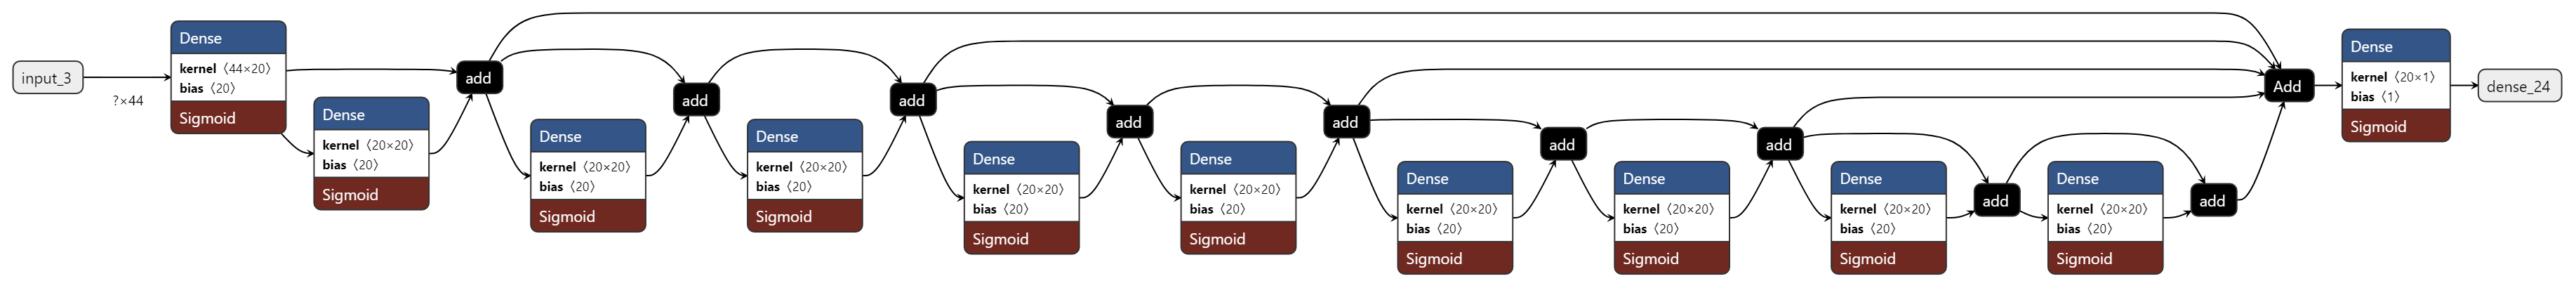

In [39]:
# Next, let's define the model. We use a single output with sigmoid for binary classification (churn or no churn?).
# A quite simple model would be enough here with a few hundreds of learnable parameters and 1-2 layers. However, to demonstrate the robustness of residual and skip connections, let's construct a neural network with:
# * 10 layers, 20 neurons / layers with sigmoid activation
# * residual connections for each layer
# * skip connections from every 2nd layer
# * an output layer with 1 neuron and sigmoid activation (as this is a binary classification problem)
# skips = []
# inp = Input(shape=(X_train.shape[1],)) # 44 dimensional
# x = Dense(20, activation='sigmoid')(inp)
# for i in range(10):
#   x = Dense(20, activation='sigmoid')(x)
#   x = Dense(20, activation='sigmoid')(x)
#   x = Dense(20, activation='sigmoid')(x)
#   skips.append(x)
# x = Add()(skips)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(inp, x)

skips = []
inp = Input(shape=(X_train.shape[1],)) # 44 dimensional
x = Dense(20, activation='sigmoid')(inp)
for i in range(10):
  x = Dense(20, activation='sigmoid')(x)
  x = Dense(20, activation='sigmoid')(x)
  x = Dense(20, activation='sigmoid')(x)
  skips.append(x)
x = Add()(skips)
x = Dense(1, activation='sigmoid')(x)
model = Model(inp, x)




In [35]:
skips = []
inp = Input(shape=(X_train.shape[1],)) # 44 dimensional
x = Dense(20, activation='sigmoid')(inp)
for i in range(10):
  x = Dense(20, activation='sigmoid')(x)
  x = Dense(20, activation='sigmoid')(x)
  x = Dense(20, activation='sigmoid')(x)
  skips.append(x)
x = Add()(skips)
x = Dense(1, activation='sigmoid')(x)
model = Model(inp, x)

By exporting the model to the [Netron.app](https://netron.app/), you can inspect the result:

In [36]:
model.save(filepath="telco_model.hdf5",save_format='h5')

Compiling and training the model:

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [38]:
es = EarlyStopping(monitor='val_loss',
                   patience=30,
                   verbose=1,
                   restore_best_weights=True)

## Training and evaluation

Start training:

In [29]:
model.fit(X_train, Y_train, epochs=1000,
          callbacks=[es],
          batch_size=32, shuffle=True,
          validation_data=(X_valid, Y_valid))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Evaluate the solution on the test dataset:

In [ ]:
model.evaluate(X_test, Y_test)

And lets explore the predictions:

In [ ]:
preds = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, np.round(preds))

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

In [ ]:
sns.histplot(preds, bins=20)